In [ ]:
import os
import tempfile

import numpy as np
import matplotlib.pyplot as plt

import h5py

from sigcorr.utils import set_plt_reasonable_defaults
from sigcorr.models.alex_exp import AlexExp
from sigcorr.models.alex_exp_asimov1bin import AlexExpAsimov1Bin
from sigcorr.models.utils import set_params_from_model
from sigcorr.fitter import Fitter
from sigcorr.stats.utils import get_delta_sigs
from sigcorr.utils import upcross_locs


set_plt_reasonable_defaults(plt)
np.random.seed(12345)

In [ ]:
OUTPUT_DIR = "img"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
sampling_grid_file = "../../grids/alex_exp-common.dat"
sampling_xs = np.genfromtxt(sampling_grid_file, dtype=np.float64)

In [ ]:
model = AlexExp(sampling_xs)
model.B0 = 1000
model.BG_NOISE_STD = 70
model.init()

In [ ]:
bg_samples = model.get_bg_samples(10)

In [ ]:
scan_grid_file = sampling_grid_file
scan_xs = np.genfromtxt(scan_grid_file, dtype=np.float64)

In [ ]:
def one_sb(sig_x, ampl):
    return model.expected_sb(sig_x, (ampl,), (model.B0, model.BG_XSCALE))

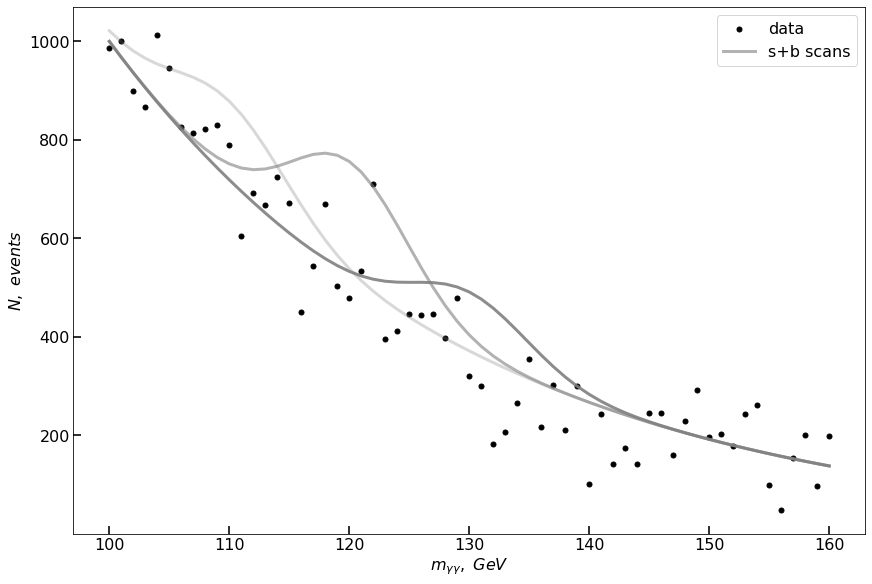

In [ ]:
plt.scatter(model.xs, bg_samples[0], color="black", label="data")
plt.plot(model.xs, one_sb(110, 2000), color="gray", lw=3, alpha=0.3)
plt.plot(model.xs, one_sb(120, 3000), color="gray", lw=3, alpha=0.6, label="s+b scans")
plt.plot(model.xs, one_sb(130, 1500), color="gray", lw=3, alpha=0.9)
plt.xlabel("$m_{\gamma\gamma},~GeV$")
plt.ylabel("$N,~events$")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "sb_scan.png"))

In [ ]:
fitter = Fitter(model, scan_xs)
true_res = {}
with tempfile.TemporaryDirectory() as tmpdir:
    tmp_file = os.path.join(tmpdir, "output.h5")
    with h5py.File(tmp_file, "w", libver="latest"):
        pass
    fitter.fit_b_loglikes(bg_samples, tmp_file)
    fitter.fit_sb_loglikes(bg_samples, tmp_file)
    fields = ["b_loglikes", "b_params", "b_params_vars",
              "sb_loglikes", "sb_params", "sb_params_vars"]
    with h5py.File(tmp_file, libver="latest", swmr=True) as fin:
        for field in fields:
            true_res[field] = fin[field][...]

Fitting B
  0%|                                                                                                                                                                                         | 0/10 [00:00<?, ?it/s]start pushing samples to B queue
send FinishProcessing to workers and wait
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.93it/s, writer_qsize=0, workers_qsize=0]
send FinishProcessing to writer and wait
done B
Fitting S+B
  0%|                                                                                                                                                                                        | 0/610 [00:00<?, ?it/s]start pushing samples to SB queue
send FinishProcessing to workers and wait
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [ ]:
true_sig = get_delta_sigs(true_res["b_loglikes"], true_res["sb_loglikes"], np.sign(true_res["sb_params"][..., 0]))

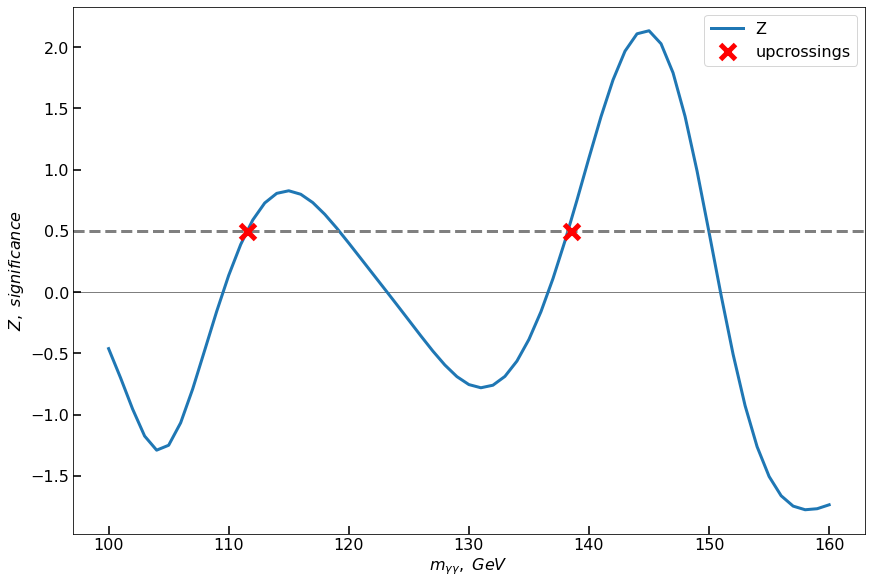

In [ ]:
sample_idx = 2
plt.axhline(0, color="black", lw=0.5)
plt.plot(scan_xs, true_sig[sample_idx], label="Z")
plt.axhline(0.5, ls="--", color="gray")
sample_upcross_locs = scan_xs[:-1][upcross_locs(true_sig[sample_idx], 0.5)] + (scan_xs[1] - scan_xs[0])/2
plt.plot(sample_upcross_locs, np.full_like(sample_upcross_locs, 0.5), ls="", ms=15, markeredgewidth=5, marker="x", color="red", label="upcrossings")
plt.xlabel("$m_{\gamma\gamma},~GeV$")
plt.ylabel("$Z,~significance$")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "sigcurve.png"))

In [ ]:
model_asimov = AlexExpAsimov1Bin(sampling_xs)
set_params_from_model(model_asimov, model)
model_asimov.xs = sampling_xs[::5]
model_asimov.B0 = 400
model_asimov.init()

In [ ]:
asimov_samples = model_asimov.get_bg_samples(None)

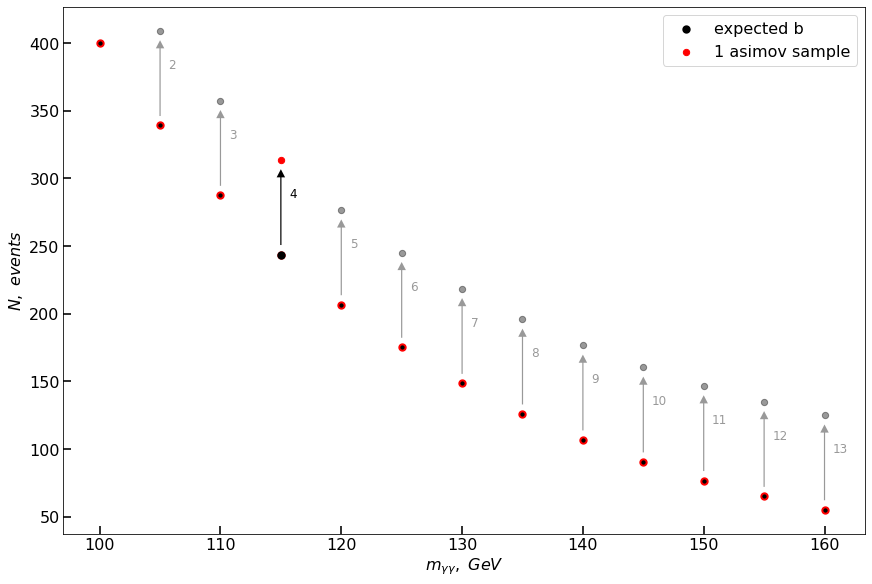

In [118]:
from matplotlib import cm
asimov_expected_bg = model_asimov.expected_b(model_asimov.B0, model_asimov.BG_XSCALE)
plt.scatter(model_asimov.xs, asimov_expected_bg, marker="o", color="black", edgecolors="red", linewidths=2, s=40)
curve_idx = 3
plt.scatter(model_asimov.xs[curve_idx], asimov_expected_bg[curve_idx], marker="o", label="expected b", linewidths=2, color="black", edgecolors="black", s=40)
for i in range(1, asimov_samples.shape[0]):
    label = "1 asimov sample" if i == curve_idx else None
    alpha = (1 if i == curve_idx else 0.4)
    color = ("red" if i == curve_idx else "black")
    plt.arrow(model_asimov.xs[i], asimov_expected_bg[i] + (asimov_samples[i, i] - asimov_expected_bg[i])*0.1, 0, (asimov_samples[i, i] - asimov_expected_bg[i])*0.8, length_includes_head=True, head_length=6, head_width=0.7, width=0.1, lw=0, color="black", alpha=alpha)
    plt.scatter(model_asimov.xs[i], asimov_samples[i, i], label=label, marker="o", alpha=alpha, s=40, color=color)
    plt.text(model_asimov.xs[i]+0.7, asimov_expected_bg[i] + (asimov_samples[i, i] - asimov_expected_bg[i])*0.6, f"{i + 1}", alpha=alpha, fontsize=12, color="black")
    #print(asimov_samples[i, i] - model_asimov.expected_b(model_asimov.B0, model_asimov.BG_XSCALE)[i])
plt.xlabel("$m_{\gamma\gamma},~GeV$")
plt.ylabel("$N,~events$")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "asimov_dataset.png"))